<a href="https://colab.research.google.com/github/ziatdinovmax/Notebooks-for-papers/blob/master/Ferroic_GP_notebook_for_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictability as a probe of manifest and latent physics

Colab notebook for our to be submitted paper.

*Prepared by Nicole Creange, Christopher Nelson and Maxim Ziatdinov*

*(March 2020)*

Check available cloud GPU (to get faster calculations for GP, try to connect to P100):

In [ ]:
!nvidia-smi

Thu Mar 19 05:36:34 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
#@title Import/Install modules { form-width: "20%" }
# system
import os
import warnings
# data manipulation
import pandas as pd
import h5py
import numpy as np
from scipy import spatial, fftpack, ndimage
from scipy.signal import find_peaks
from scipy.interpolate import griddata
from sklearn.cross_decomposition import CCA
from skimage.transform import radon
import pdb
# gaussian processes
try:
    import pyro
except ModuleNotFoundError:
    print("Installing Pyro probabilistic programming library...", end=" ")
    !pip install pyro-ppl==1.1.0 > /dev/null
    print("Done")
    import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import torch
# plotting
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
import seaborn as sns
import matplotlib.cm as cm

from tqdm import tqdm, trange

pyro.set_rng_seed(0)
torch.random.manual_seed(0)
warnings.filterwarnings("ignore", category=UserWarning);

Installing Pyro probabilistic programming library... Done


In [2]:
#@title Helper functions
def remove_edge_points(feature, coordinates, dist_edge):
        
    def coord_edges(coord, coordinates, dist_edge):
        return [coord[0] > np.amax(coordinates[:, 0]) - dist_edge,
                coord[0] < np.amin(coordinates[:, 0]) + dist_edge,
                coord[1] > np.amax(coordinates[:, 1]) - dist_edge,
                coord[1] < np.amin(coordinates[:, 1]) + dist_edge]

    idx_to_rem = [
                  idx for idx, c in enumerate(coordinates)
                  if any(coord_edges(c, coordinates, dist_edge))]
    feature = np.delete(feature, idx_to_rem, axis=0)
    return feature
    

def ccacoef(X, Y, scale=True):
    X = X[:, np.newaxis] if np.ndim(X) == 1 else X
    Y = Y[:, np.newaxis] if np.ndim(Y) == 1 else Y
    if scale:
        X = (X - np.mean(X)) / np.std(X)
        Y = (Y - np.mean(Y)) / np.std(Y)
    cca = CCA(n_components=1)
    cca.fit(X, Y)
    X_c, Y_c = cca.transform(X, Y)
    return np.corrcoef(X_c.T, Y_c.T)[0,1]

Download files with experimental data:

In [3]:
!gdown https://drive.google.com/uc?id=1---ghEz567TbnnwuEwvTt5W_9_435ixr
!unzip ferroicGP_files.zip 

Downloading...
From: https://drive.google.com/uc?id=1---ghEz567TbnnwuEwvTt5W_9_435ixr
To: /content/ferroicGP_files.zip
76.0MB [00:01, 62.5MB/s]
Archive:  ferroicGP_files.zip
   creating: files/
  inflating: files/SBFO_high Sm_HAADF.h5  
  inflating: files/SBFO_high Sm_UCParameterization.h5  
  inflating: files/SBFO_intermediate Sm_HAADF.h5  
  inflating: files/SBFO_intermediate Sm_UCParameterization.h5  
  inflating: files/SBFO_low Sm_HAADF.h5  
  inflating: files/SBFO_low Sm_UCParameterization.h5  


Choose files of interest and view the corresponding image and available UC parameters:

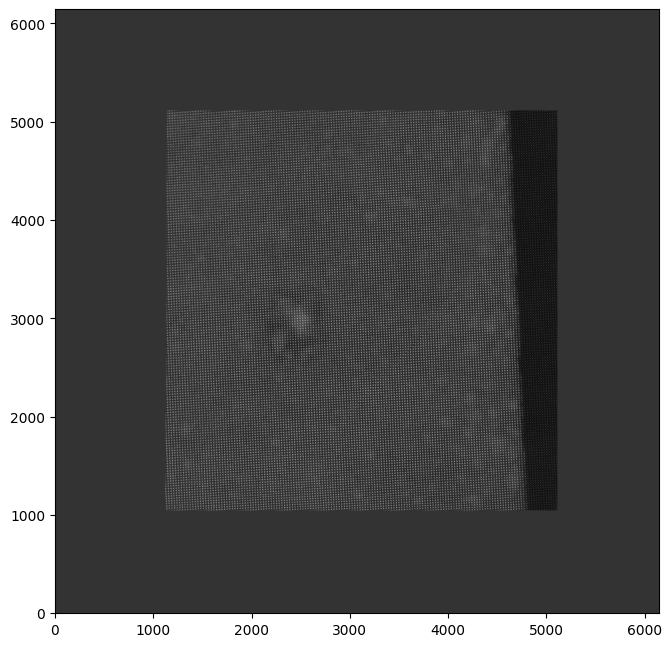

UC parameterization: ['I1', 'I2', 'I3', 'I4', 'I5', 'NCOM', 'PCOM', 'Pxy', 'Vol', 'a', 'ab', 'adelta', 'alpha', 'atmindex', 'b', 'bdelta', 'index', 'meanuca', 'meanucb', 'nbrUC', 'xy_COM', 'xy_atms']


In [4]:
filedir = './files'

img_filename = 'SBFO_low Sm_HAADF.h5' #image files, e.g. 'SBFO_low Sm_HAADF.h5' 'SBFO_intermediate Sm_HAADF.h5' or 'SBFO_high Sm_HAADF.h5'
UCparam_filename = 'SBFO_low Sm_UCParameterization.h5' # unit cell param files, e.g. 'SBFO_low Sm_UCParameterization.h5' 'SBFO_intermediate Sm_UCParameterization.h5' or 'SBFO_high Sm_UCParameterization.h5'

img = h5py.File(os.path.join(filedir, img_filename), 'r')
UCparam = h5py.File(os.path.join(filedir, UCparam_filename), 'r')
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(img['MainImage'], origin='bottom', cmap='gray')
plt.show()
print('UC parameterization:', [k for k in UCparam.keys()])

You can view x and y polarization components:

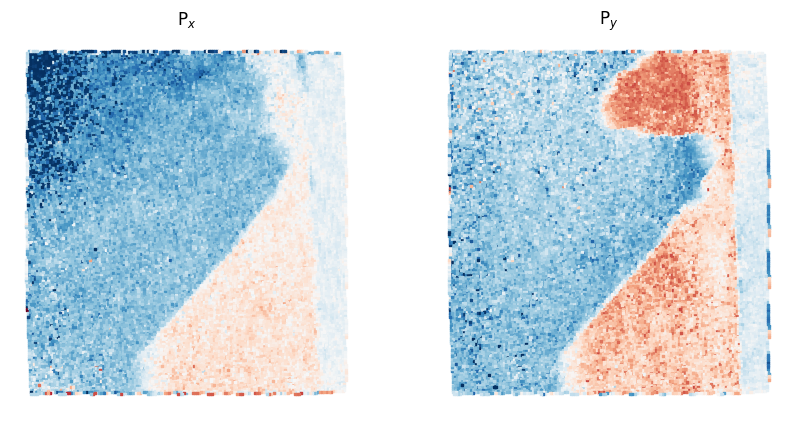

In [5]:
xy_COM = UCparam['xy_COM'][()].T
Pxy = UCparam['Pxy'][()].T

percentile = 99
Pxybounds = np.nanpercentile(np.abs(np.hstack((Pxy[:,0],Pxy[:,1]))),percentile)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax1.scatter(xy_COM[:, 1], xy_COM[:, 0], c=Pxy[:, 0], marker='s', s=2, cmap='RdBu', vmin=-Pxybounds, vmax=Pxybounds)
ax1.title.set_text('P$_x$')
ax1.axis('off')
ax2.scatter(xy_COM[:, 1], xy_COM[:, 0], c=Pxy[:, 1], marker='s', s=2, cmap='RdBu', vmin=-Pxybounds, vmax=Pxybounds)
ax2.title.set_text('P$_y$')
ax2.axis('off');


One can also visualize real space maps of the different descriptors. Below we show maps for I1 and I5 descriptors:

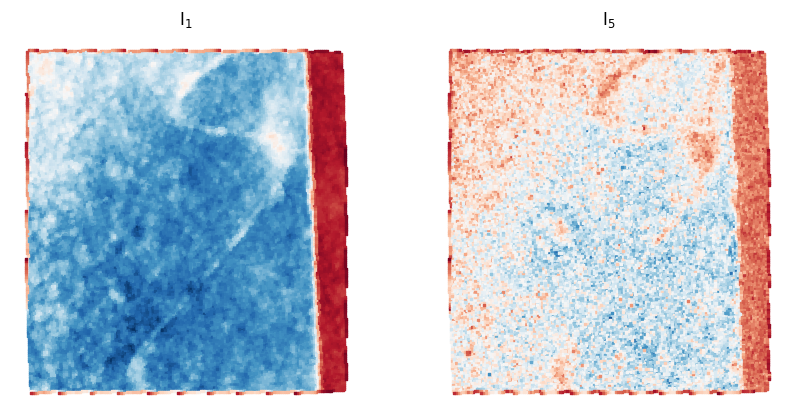

In [8]:
xy_COM = UCparam['xy_COM'][()].T
descriptor1 = UCparam['I1'][()].T 
descriptor2 = UCparam['I5'][()].T

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), dpi=100)
ax1.scatter(xy_COM[:, 1], xy_COM[:, 0], c=descriptor1, marker='s', s=2, cmap='RdBu')
ax1.title.set_text('I$_1$')
ax1.axis('off')
ax2.scatter(xy_COM[:, 1], xy_COM[:, 0], c=descriptor2, marker='s', s=2, cmap='RdBu')
ax2.title.set_text('I$_5$')
ax2.axis('off');

We can plot joint distribution for the selected variables:

<Figure size 576x576 with 0 Axes>

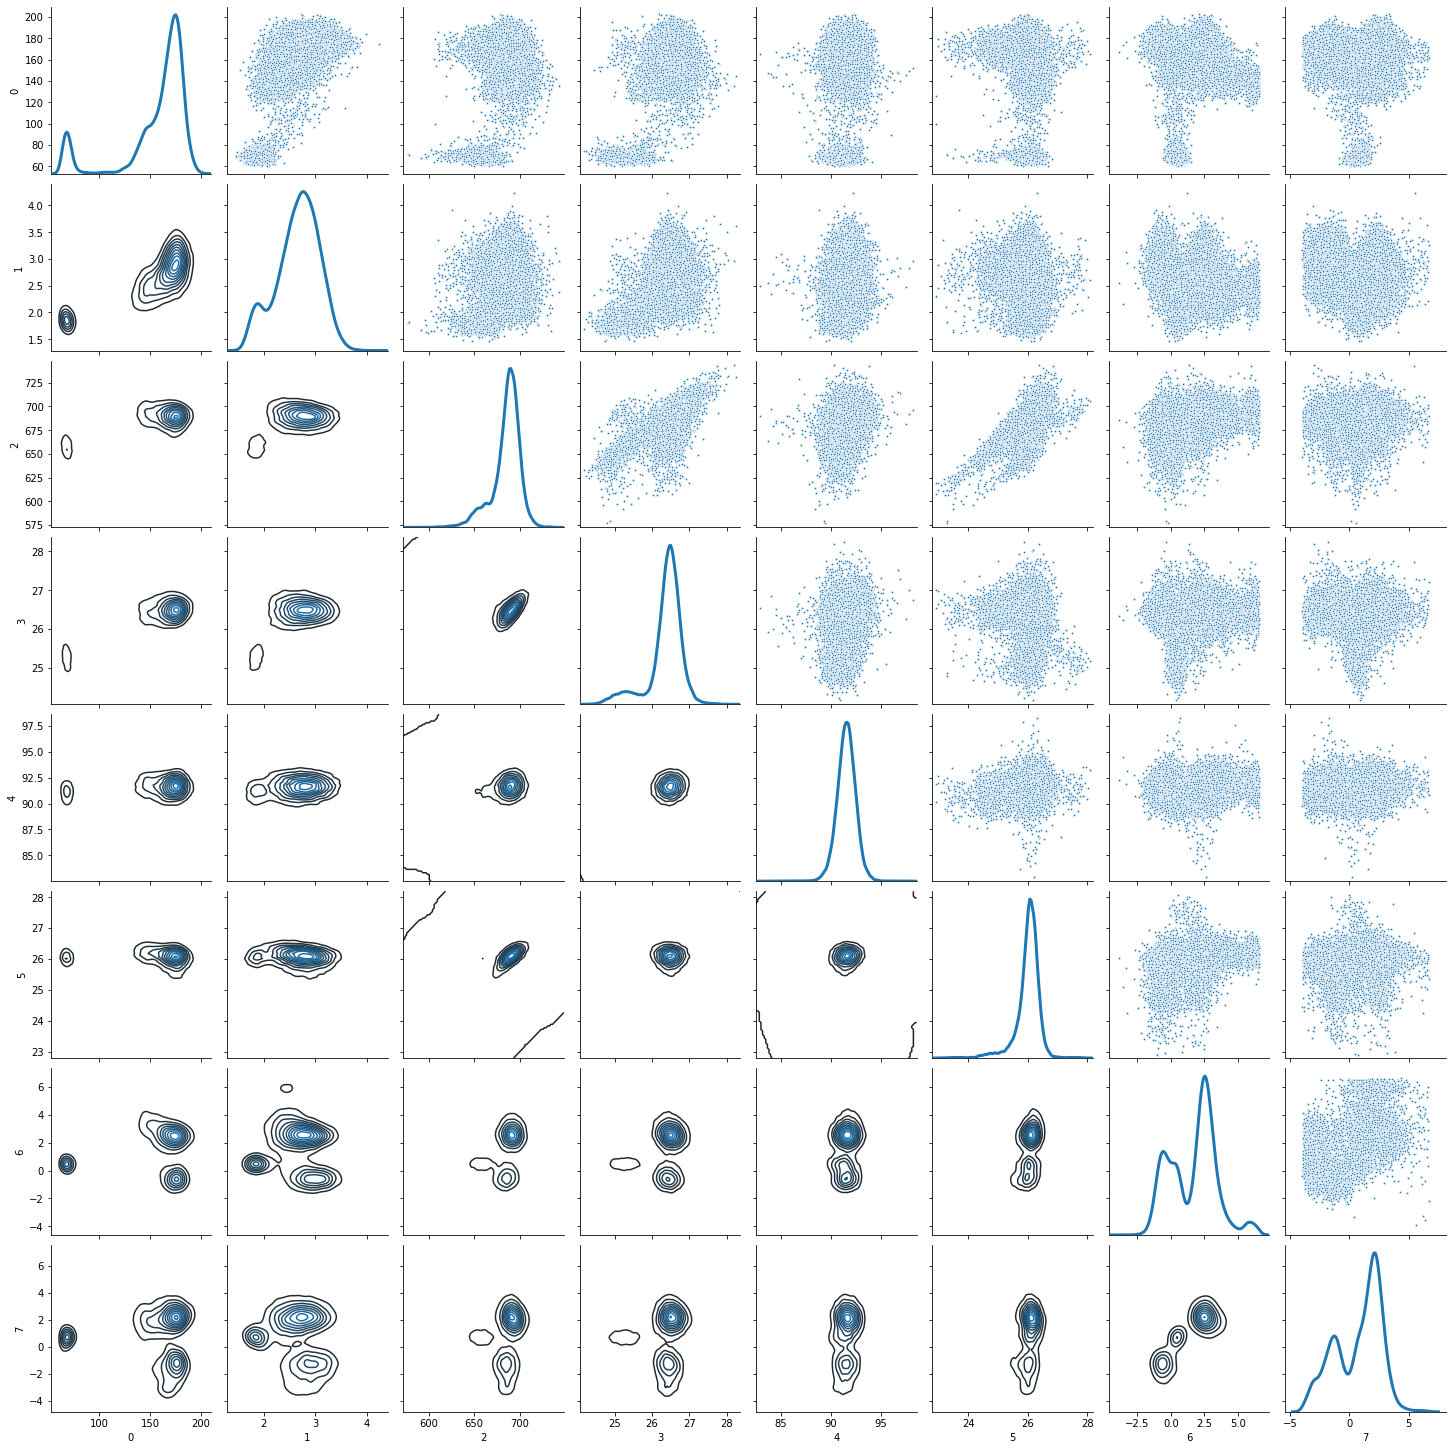

In [ ]:
# Specify variables you want to plot here
cols = [
        UCparam['I1'][()][0, :],
        UCparam['I5'][()][0, :],
        UCparam['Vol'][()][0, :],
        np.linalg.norm(UCparam['a'][()],axis=0),
        UCparam['alpha'][()][0, :],
        np.linalg.norm(UCparam['b'][()],axis=0),
        UCparam['Pxy'][()][0, :],
        UCparam['Pxy'][()][1, :],
]

cols = np.array(cols).T
cols = remove_edge_points(cols, xy_COM, 50)
cols = pd.DataFrame(cols)
plt.figure(figsize=(8, 8))
g = sns.PairGrid(cols, diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot, s=7)
g.map_diag(sns.kdeplot, lw=3)

Let's define a Gaussian process (GP) model that we are going to use to predict polarization.

In [ ]:
def GP_Regressor(X, y, **kwargs):
    """
    Performs exact gaussian process regression 
    for variable with < 2000 data points.
    Performs sparse gaussian process regression
    for variable with > 2000 points.
    Args:
        X: numpy array
            ndarray of features, with dimensions (n_samples x n_features)
        y: numpy array
            ndarray with function falues, with dimensions (n_samples,)
        **epochs: int
            number of iterations
        **verbose: bool
            prints current epoch
    Returns:
        calculated mean and variance
    """
    pyro.clear_param_store()
    epochs = kwargs.get('epochs', 500)
    verbose = kwargs.get('verbose', False)
    X = X[:, np.newaxis] if np.ndim(X) == 1 else X
    y = y[:, 0] if np.ndim(y) > 1 else y
    if torch.cuda.is_available():
        torch.set_default_tensor_type(torch.cuda.FloatTensor)
    else:
        torch.set_default_tensor_type(torch.FloatTensor)
    X = torch.from_numpy(X)
    y = torch.from_numpy(y)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        X, y = X.cuda(), y.cuda()
    if len(X) < 2000:
        gpr = gp.models.GPRegression(
            X, y, gp.kernels.RBF(input_dim=X.shape[-1]))
    else:
        indp_step = int(5e-4 * len(X))
        gpr = gp.models.SparseGPRegression(
            X, y, 
            gp.kernels.RBF(input_dim=X.shape[-1]), 
            Xu=torch.tensor(X[::indp_step]), 
            jitter=1.0e-5)
    if torch.cuda.is_available():
        gpr.cuda()
    optimizer = torch.optim.Adam(gpr.parameters(), lr=5e-2)
    loss_fn = pyro.infer.Trace_ELBO().differentiable_loss
    for i in range(epochs):
        optimizer.zero_grad()
        loss = loss_fn(gpr.model, gpr.guide)
        loss.backward()
        optimizer.step()
        if verbose:
            print('\rIteration {} / {}'.format(i+1, epochs), end="")
    with torch.no_grad():
            mean, cov = gpr(X, full_cov=False, noiseless=False)
    return mean.cpu().numpy(), cov.cpu().numpy(), 

## Structure -> Polarization

Specify inputs, outputs, and run GP:  
(This section may take some time as you are preforming GP on each of the descriptor groups)

In [ ]:
X = [np.concatenate(
    (
        UCparam['I1'][()][0, :][:, None],
        UCparam['I5'][()][0, :][:, None],
        UCparam['Vol'][()][0, :][:, None],
        np.linalg.norm(UCparam['a'][()],axis=0)[:,None],
        UCparam['alpha'][()][0, :][:, None],
        np.linalg.norm(UCparam['b'][()],axis=0)[:,None]
    ), axis=1),  # GROUP 1
    np.concatenate(
    (
        np.linalg.norm(UCparam['a'][()],axis=0)[:,None],
        np.linalg.norm(UCparam['b'][()],axis=0)[:,None]
    ), axis=1),  # GROUP 2
    np.concatenate(
    (
        UCparam['Vol'][()][0, :][:, None],
        np.linalg.norm(UCparam['a'][()],axis=0)[:,None],
        UCparam['alpha'][()][0, :][:, None],
        np.linalg.norm(UCparam['b'][()],axis=0)[:,None]
    ), axis=1),  # GROUP 3
    np.concatenate(
    (
        UCparam['Vol'][()][0, :][:, None],
        UCparam['alpha'][()][0, :][:, None],
    ), axis=1),  # GROUP 4
    np.concatenate(
    (
        UCparam['I1'][()][0, :][:, None],
        UCparam['I5'][()][0, :][:, None],
    ), axis=1)   # GROUP 5
    ]
    
scaleX = False # normalize input vector
scaleY = False # notmalize output vector

predictions = []
variances = []
# Specify outputs (polarization)
y = UCparam['Pxy'][()][1, :][:, np.newaxis] # Py
# Remove edge points
for ii in tqdm(range(len(X))):
  Xx = remove_edge_points(X[ii], UCparam['xy_COM'][()].T, 50)
  if ii == 0:
    y = remove_edge_points(y, UCparam['xy_COM'][()].T, 50)
  # Normalize data
  if scaleX:
      Xx = (Xx - np.mean(Xx)) / np.std(Xx)
  if scaleY:
      y = (y - np.mean(y)) / np.std(y)
  # Run GP regression    
  pred, var = GP_Regressor(Xx, y)
  predictions.append(pred)
  variances.append(var)

100%|██████████| 5/5 [18:52<00:00, 226.88s/it]


Plot original data, prediction and uncertainty for each predicted point:

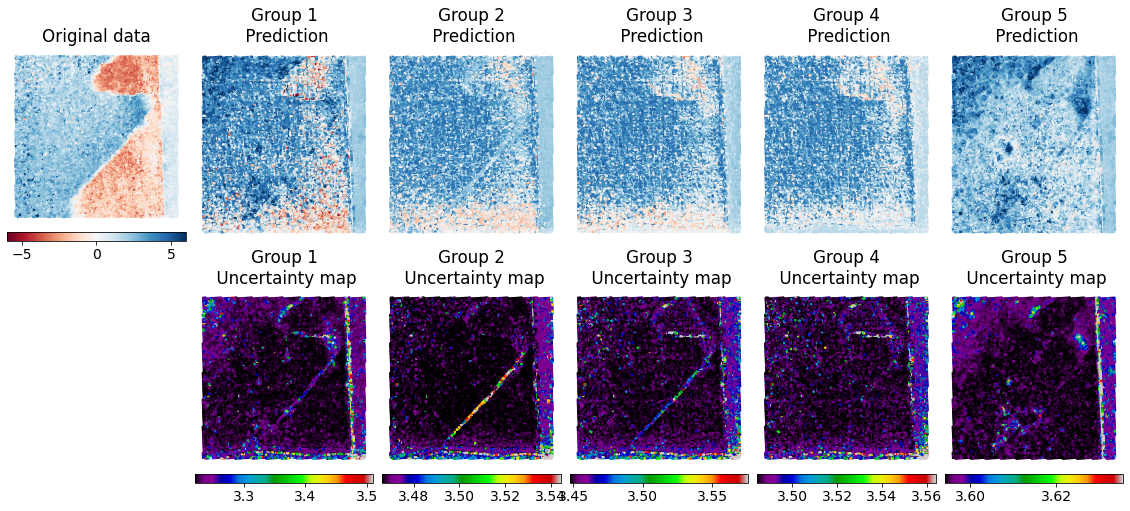

In [ ]:
plt.rcParams.update({'font.size': 14})
labels = ['Group '+str(i+1) for i in range(len(predictions))]

#color scale settings
Py_pred_clrscalar = 1/3     #a manual color axis scalar of the predicted Py values relative to original data
percentile = 99

xy_COM_to_plot = remove_edge_points(
    UCparam['xy_COM'][()].T, UCparam['xy_COM'][()].T, 50)

fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(20, 8))
im0 = axs[0,0].scatter(xy_COM_to_plot[:, 1],
            xy_COM_to_plot[:, 0],
            c=y[:, 0],
            s=2, cmap='RdBu', 
            vmin=-Pxybounds, 
            vmax=Pxybounds)
axs[0,0].axis('off')
axs[0,0].set_title('Original data')
divider = make_axes_locatable(axs[0,0])
cax0 = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
fig.add_axes(cax0)
fig.colorbar(im0, cax=cax0, orientation="horizontal")
axs[1,0].axis('off')
kk=0
jj=1
for ii in range(len(predictions)):
  im0=axs[0,jj].scatter(xy_COM_to_plot[:, 1],
              xy_COM_to_plot[:, 0],
              c = predictions[ii],
              s=2, cmap='RdBu', 
              vmin=-Pxybounds*Py_pred_clrscalar, 
              vmax=Pxybounds*Py_pred_clrscalar)
  axs[0,jj].set_title(labels[ii]+'\n Prediction')
  axs[0,jj].axis('off')
  im = axs[1,jj].scatter(xy_COM_to_plot[:, 1], 
                  xy_COM_to_plot[:, 0], 
                  c=variances[ii],
                  cmap='nipy_spectral', s=2)
  divider = make_axes_locatable(axs[1,jj])
  cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
  fig.add_axes(cax)
  fig.colorbar(im, cax=cax, orientation="horizontal")
  varbounds = np.array([np.percentile(variances[ii],100-percentile), np.percentile(variances[ii],percentile)])
  im.set_clim(varbounds[0], varbounds[1])
  #im.set_clim(np.mean(variances[ii])-.25*np.std(variances[ii]), np.mean(variances[ii])+.25*np.std(variances[ii])) # Adjust constrast as needed!!
  axs[1,jj].set_title(labels[ii]+'\n Uncertainty map')
  axs[1,jj].axis('off')
  jj+=1

plt.subplots_adjust(wspace=0.05,hspace=0.25)

Save results:

In [ ]:
#mydir = '/content/'
#mydir = '/content/drive/My Drive/Colab Notebooks/Outputs/'
#fprefix = os.path.splitext(img_filename)[0]
#np.save(os.path.join(
#    mydir, 'GP_'+fprefix+'_descriptor_predictions.npy'), 
#    [predictions, variances])

Calculate and plot correlation coefficient for different groups of structural descriptors *vs* one of the polarization components.

## Polarization -> Polarization

Let's rearange unit cell parameters for the GP analysis. First, we need to know the mean nearest neighbor distance (for unit cells) and its standard deviation:

In [ ]:
xy_COM = UCparam['xy_COM'][()].T
Pxy = UCparam['Pxy'][()].T

nnd = spatial.cKDTree(xy_COM).query(xy_COM, k=2)
nnd_aver = np.mean(nnd[0][:, 1])
nnd_sd = np.std(nnd[0][:, 1])
print(nnd_aver.item(), nnd_sd.item())

25.74879138446179 0.6349962562432555


Get polarization values for 8 nearest neighbors of each cell (and the "central cell" itself):

In [ ]:
tree = spatial.cKDTree(xy_COM)
nn9 = tree.query(xy_COM, k=9, distance_upper_bound=(nnd_aver+3*nnd_sd) * 1.73)
idx_to_del = np.where(nn9[0] == np.inf)[0]
xy_COM_r = np.delete(xy_COM, idx_to_del, axis=0)
nn9 = np.delete(nn9[1], idx_to_del, axis=0)
Pxy9 = Pxy[nn9]

Now let's split them into future inputs and outputs of a neural network. 

In [ ]:
Px1, Px8 = Pxy9[:, 0:1, 0], Pxy9[:, 1:, 0]
Py1, Py8 = Pxy9[:, 0:1, 1], Pxy9[:, 1:, 1]

Specify inputs, output, and run GP analysis:

In [ ]:
# Inputs and outputs
X = [Py8.copy(),Px8.copy()]
y = Py1.copy()
# Scale option
scaleX = False # normalize input vector
scaleY = False # notmalize output vector
# Remove edge points
predictions8 = []
variances8 = []
y = remove_edge_points(y, xy_COM_r, 50)
for ii in trange(len(X)):
  Xx = remove_edge_points(X[ii], xy_COM_r, 50)
  # Normalize data
  if scaleX:
      Xx = (Xx - np.mean(Xx)) / np.std(Xx)
  if scaleY:
      y = (y - np.mean(y)) / np.std(y)
  # Run GP regression    
  pred, var = GP_Regressor(Xx, y)
  predictions8.append(pred)
  variances8.append(var)

100%|██████████| 2/2 [07:09<00:00, 214.79s/it]


Plot results:

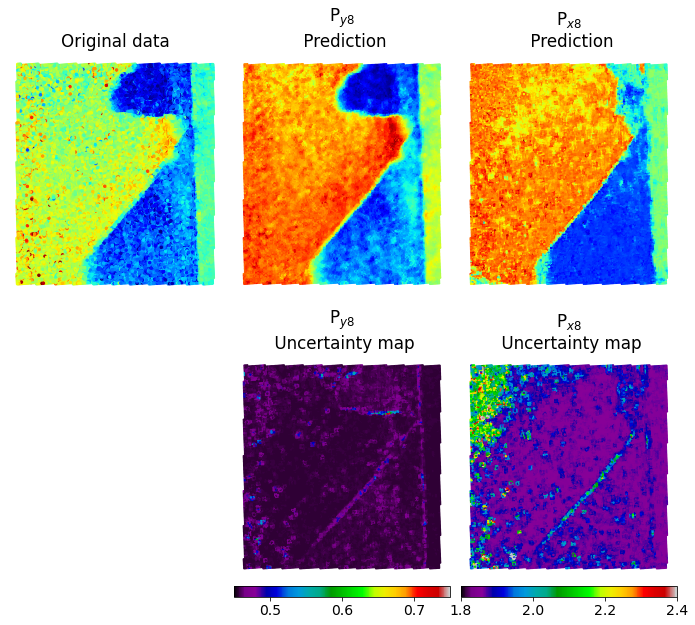

In [ ]:
lbs8 = ['P$_{y8}$','P$_{x8}$']

xy_COM_to_plot = remove_edge_points(xy_COM_r, xy_COM_r, 50)
cbar_lims=[(0.45,0.75),(1.8,2.4)]
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 10))
axs[0,0].scatter(xy_COM_to_plot[:, 1],
            xy_COM_to_plot[:, 0],
            c=y[:, 0],
            cmap='jet', s=6)
axs[0,0].set_title('Original data')
axs[0,0].axis('off')
axs[1,0].axis('off')
jj=1
for ii in range(len(X)):
  axs[0,jj].scatter(xy_COM_to_plot[:, 1],
              xy_COM_to_plot[:, 0],
              c = predictions8[ii],
              cmap='jet', s=2)
  axs[0,jj].set_title(lbs8[ii]+'\n Prediction')
  axs[0,jj].axis('off')
  im = axs[1,jj].scatter(xy_COM_to_plot[:, 1], 
                  xy_COM_to_plot[:, 0], 
                  c=variances8[ii],
                  cmap='nipy_spectral', s=2)
  axs[1,jj].set_title(lbs8[ii]+'\n Uncertainty map')
  axs[1,jj].axis('off')
  divider = make_axes_locatable(axs[1,jj])
  cax = divider.new_vertical(size="5%", pad=0.1, pack_start=True)
  fig.add_axes(cax)
  fig.colorbar(im, cax=cax, orientation="horizontal")
  im.set_clim(cbar_lims[ii])
  jj+=1
plt.subplots_adjust(wspace=0.05,hspace=0.25)


Save results:

In [ ]:
#mydir = '/content/'
#np.save(os.path.join(
#    mydir, 'GP_03site7_polarization_predictions.npy'), 
#    [predictions8, variances8])

## Correlation analysis

Explore correlations:

In [ ]:
preds8 = predictions8
preds = predictions

X_to_cor = [Py8.copy(),Px8.copy()]
# Specify Px or Py for which we will calculate the correlation
Y_to_cor = Py1.copy()
Ypred_to_cor = predictions8
# Calculate correlation coefficient
stdrz = lambda v: (v - np.mean(v)) / np.std(v)
rmep = lambda d: remove_edge_points(d, xy_COM_r, 50)
Y_to_cor = rmep(Y_to_cor)
corr_list1=[ccacoef(stdrz(rmep(val)), Y_to_cor) for val in X_to_cor]
corr_list_pred1=[ccacoef(stdrz(rmep(X_to_cor[val])), Ypred_to_cor[val]) for val in range(len(X_to_cor))]
corr_list_pred_truth1=[ccacoef(stdrz(val), Y_to_cor) for val in Ypred_to_cor]

# Specify list with values for wich you want a correlation with Px/Py 
X_to_cor  = [# group 1
            [
              UCparam['I1'][()][0, :][:, None],
              UCparam['I5'][()][0, :][:, None],
              UCparam['Vol'][()][0, :][:, None],
              np.linalg.norm(UCparam['a'][()],axis=0)[:,None],
              UCparam['alpha'][()][0, :][:, None],
              np.linalg.norm(UCparam['b'][()],axis=0)[:,None]
            ] ,
            # group 2
            [
              np.linalg.norm(UCparam['a'][()],axis=0)[:,None],
              np.linalg.norm(UCparam['b'][()],axis=0)[:,None]
            ],
            # group 3
            [
              UCparam['Vol'][()][0, :][:, None],
              np.linalg.norm(UCparam['a'][()],axis=0)[:,None],
              np.linalg.norm(UCparam['b'][()],axis=0)[:,None],
              UCparam['alpha'][()][0, :][:, None]
            ],
            # group 4
            [
              UCparam['Vol'][()][0, :][:, None],
              UCparam['alpha'][()][0, :][:, None]
            ],
            
            # group 5
            [
              UCparam['I1'][()][0, :][:, None],
              UCparam['I5'][()][0, :][:, None]
            ]
            ]
# Specify Px or Py for which we will calculate the correlation
Y_to_cor = UCparam['Pxy'][()][1, :][:, None] # Py
Ypred_to_cor = predictions
# Calculate correlation coefficient
stdrz = lambda v: (v - np.mean(v)) / np.std(v)
rmep = lambda d: remove_edge_points(d, UCparam['xy_COM'][()].T, 50)
Y_to_cor = rmep(Y_to_cor)
corr_list2=[
    ccacoef(stdrz(rmep(np.concatenate(val,-1))), Y_to_cor) for val in X_to_cor]
corr_list_pred2=[
    ccacoef(stdrz(rmep(np.concatenate(X_to_cor[val],-1))), Ypred_to_cor[val][:,None]) for val in range(len(X_to_cor))]
corr_list_pred_truth2=[
    ccacoef(stdrz(np.concatenate(val[:,None],-1)), Y_to_cor) for val in Ypred_to_cor]

corr_list=corr_list1+corr_list2
corr_list_pred=corr_list_pred1+corr_list_pred2
corr_list_pred_truth=corr_list_pred_truth1+corr_list_pred_truth2

Plot correlation results:

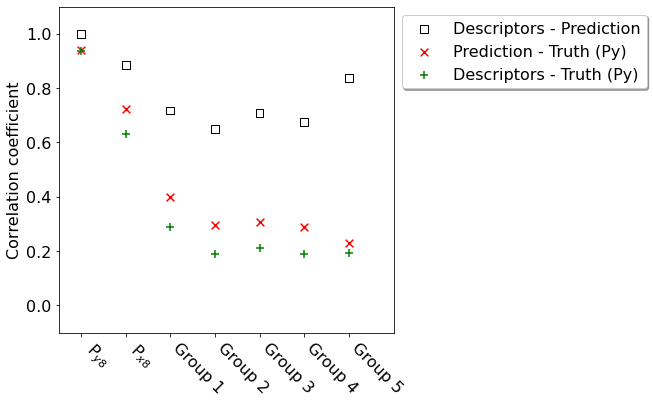

In [ ]:
plt.rcParams.update({'font.size': 16})

lbs = ['P$_{y8}$','P$_{x8}$']
labels = lbs+['Group '+str(i+1) for i in range(5)]

fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(np.arange(len(labels)), np.abs(np.asarray(corr_list_pred)), marker='s', edgecolors='k', facecolors='none' , s=60,label='Descriptors - Prediction')
ax.scatter(np.arange(len(labels)), np.abs(np.asarray(corr_list_pred_truth)), marker='x', c='r', s=60,label='Prediction - Truth (Py)')
ax.scatter(np.arange(len(labels)), np.abs(np.asarray(corr_list)),marker='+', c='green', facecolors='none',s=60,label='Descriptors - Truth (Py)')

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-45, ha='left')

ax.set_ylabel('Correlation coefficient')
ax.legend()
ax.set_xlim(-0.5, len(corr_list))
ax.set_ylim(-0.1, 1.1)

lgd=ax.legend(ncol=1,bbox_to_anchor=(1,1), loc="upper left",shadow=True)


Violin plots of Uncertainty for each descriptor group.

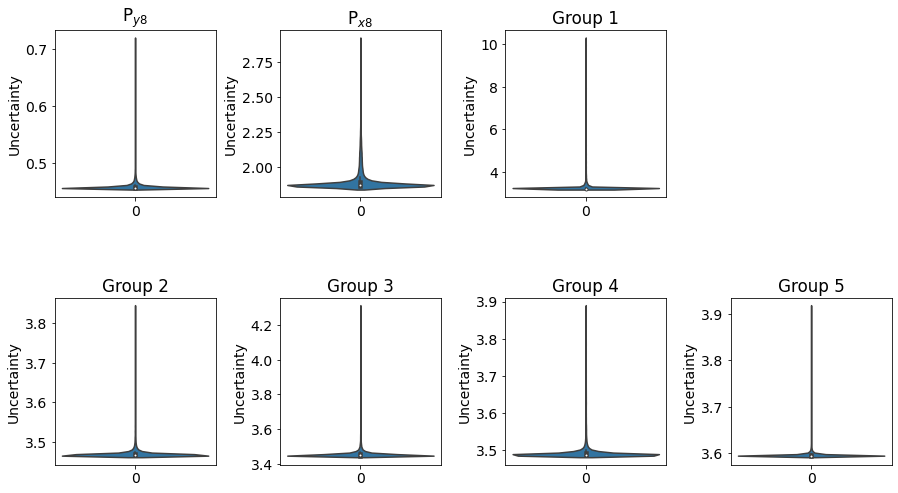

In [ ]:
plt.rcParams.update({'font.size': 14})

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
plt.subplots_adjust(wspace=0.4, hspace=0.6)
all_vars = variances8+variances

jj=0
kk=0
for ii in range(len(labels)):
  if kk==3 and jj==0:
    axs[jj,kk].axis('off')
    jj=1
    kk=0
  g=sns.violinplot(data=all_vars[ii],ax=axs[jj,kk])
  axs[jj,kk].title.set_text(labels[ii])
  axs[jj,kk].set_ylabel('Uncertainty')
  kk+=1

Plotting the average uncertainty for each descriptor group.

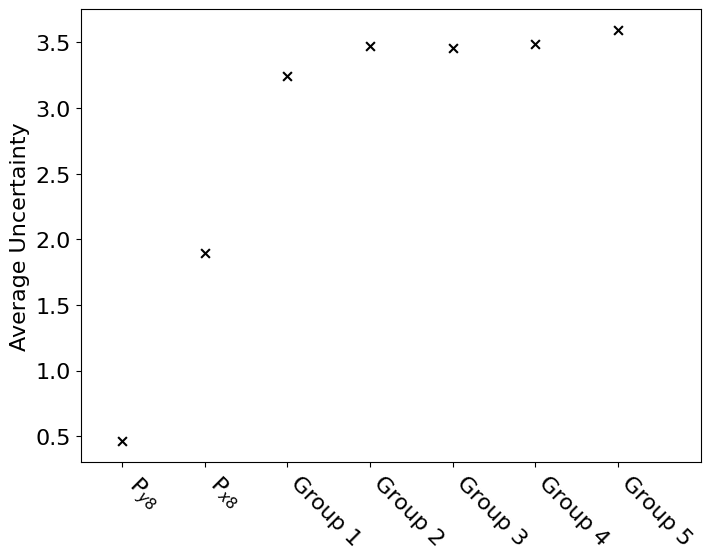

In [ ]:
plt.rcParams.update({'font.size': 16})

avg_vars = [np.mean(k) for k in all_vars]

fig,ax=plt.subplots(figsize=(8,6),dpi=100)
ax.scatter(np.arange(len(avg_vars)),avg_vars, marker='x', c='black', s=40)

ax.set_xticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=-45, ha='left')
ax.set_ylabel('Average Uncertainty')
ax.set_xlim(-0.5, len(labels));


Linear interpolation grid of each prediction in order to calculate FFTs.

In [ ]:
xy_COM_to_plot = remove_edge_points(UCparam['xy_COM'][()].T, UCparam['xy_COM'][()].T, 50)
xy_COM_to_plot8 = remove_edge_points(xy_COM_r, xy_COM_r, 50)
xi = np.linspace(xy_COM_to_plot[:,0].min(), xy_COM_to_plot[:,0].max(), 5000)
yi = np.linspace(xy_COM_to_plot[:,1].min(), xy_COM_to_plot[:,1].max(), 5000)
xi, yi = np.meshgrid(xi, yi)
xi8 = np.linspace(xy_COM_to_plot8[:,0].min(), xy_COM_to_plot8[:,0].max(), 5000)
yi8 = np.linspace(xy_COM_to_plot8[:,1].min(), xy_COM_to_plot8[:,1].max(), 5000)
xi8, yi8 = np.meshgrid(xi8, yi8)
grids_data = []
# Py original data grid for FFT
xi_og = np.linspace(xy_COM[:,0].min(), xy_COM[:,0].max(), 5000)
yi_og = np.linspace(xy_COM[:,1].min(), xy_COM[:,1].max(), 5000)
xi_og, yi_og = np.meshgrid(xi_og, yi_og)
grid_z0 = griddata(xy_COM, Pxy[:,1], (xi_og, yi_og), method='nearest')
grid_z1 = griddata(xy_COM, Pxy[:,1], (xi_og, yi_og), method='linear')
mask=np.isfinite(grid_z1)
grids_data.append(mask*grid_z0)
# Py8,Px8 predictions data grid for FFT
for ii in predictions8:
  grid_z0 = griddata(xy_COM_to_plot8, ii, (xi8, yi8), method='nearest')
  grid_z1 = griddata(xy_COM_to_plot8, ii, (xi8, yi8), method='linear')
  mask=np.isfinite(grid_z1)
  grids_data.append(mask*grid_z0)
# Descriptor group predictions data grid for FFT
for ii in predictions:
  grid_z0 = griddata(xy_COM_to_plot, ii, (xi, yi), method='nearest')
  grid_z1 = griddata(xy_COM_to_plot, ii, (xi, yi), method='linear')
  mask=np.isfinite(grid_z1)
  grids_data.append(mask*grid_z0)


Plot prediction and corresponding FFT for each predictor group.

Text(0, 0.5, 'Group 5 \n Prediction')

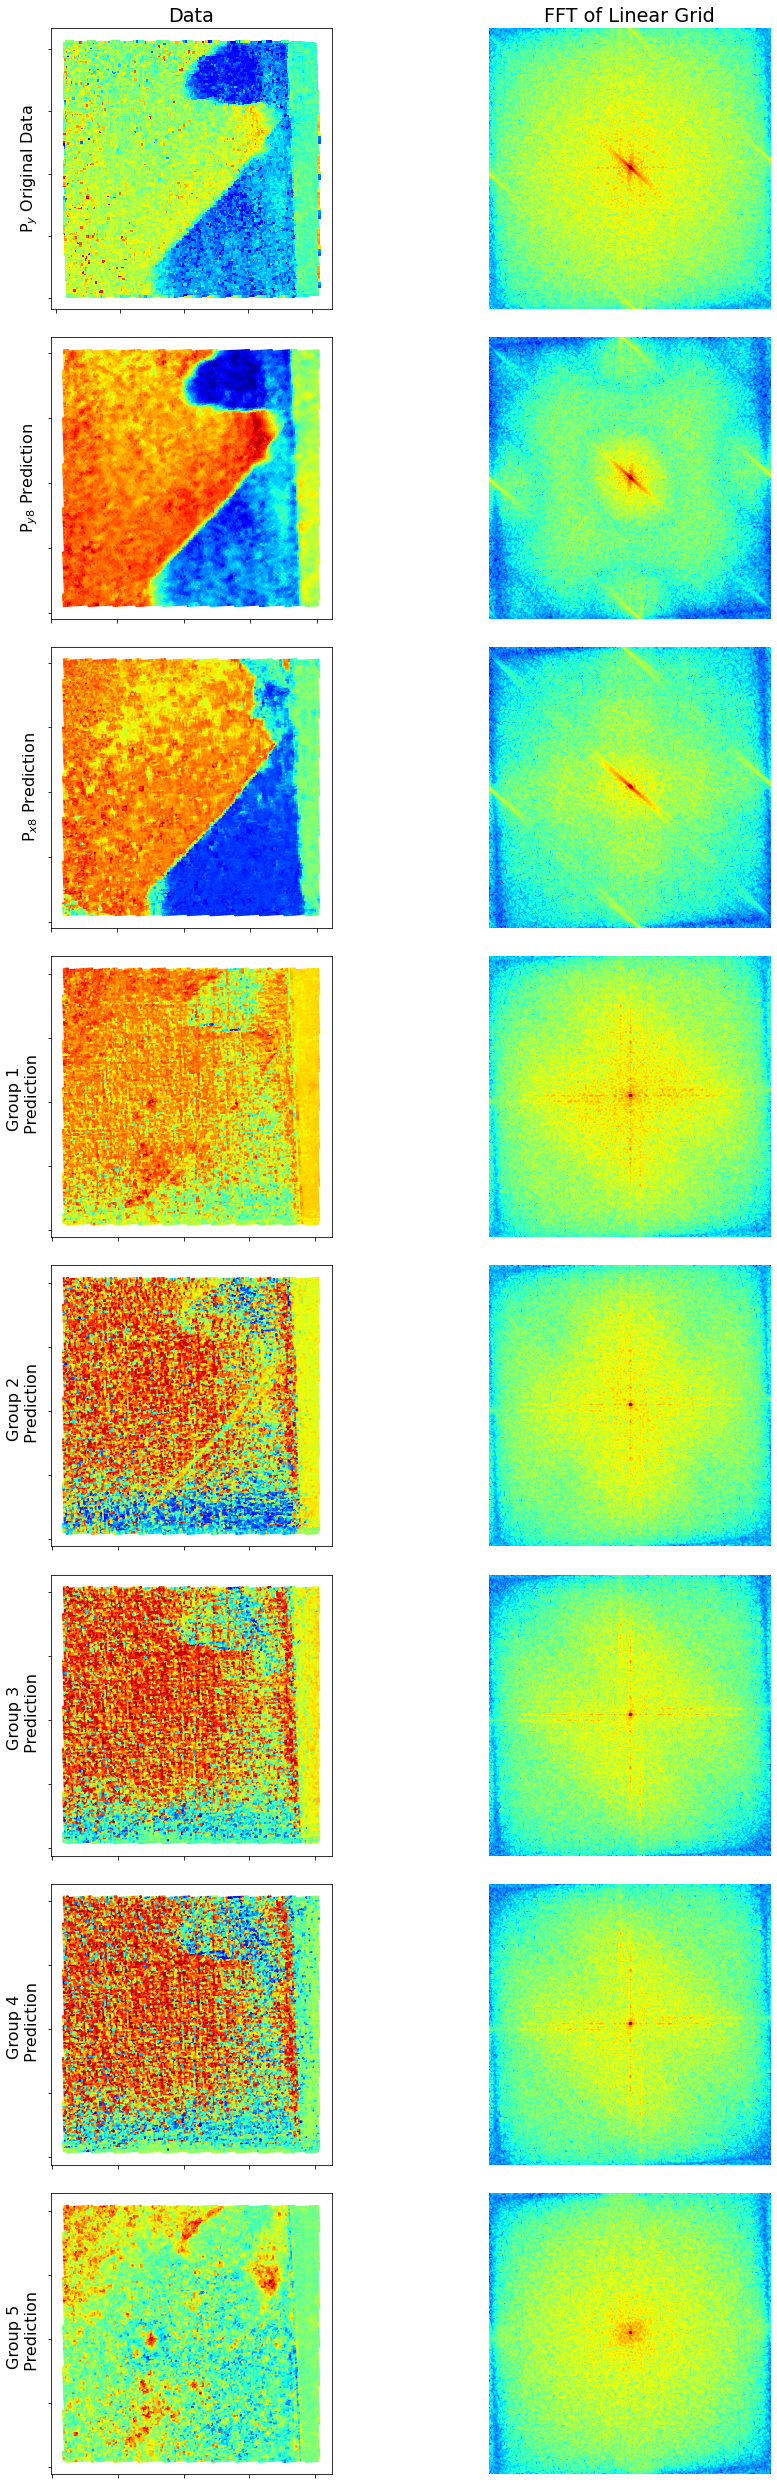

In [ ]:
plt.rcParams.update({'font.size': 16})

fig,ax = plt.subplots(nrows=8,ncols=2,figsize=(15,45))
ax[0,0].scatter(xy_COM[:, 1], xy_COM[:, 0], c=Pxy[:, 1], marker='s', s=3, cmap='jet')
asp = np.diff(ax[0,0].get_xlim())[0] / np.diff(ax[0,0].get_ylim())[0]
ax[0,0].set_aspect(asp)
ax[0,0].set_yticklabels([])
ax[0,0].set_xticklabels([])
jj=-1
kk=-1
pp=-1
U=150
FFTs = []

for ii in grids_data:
  jj+=1
  if jj<3:
    nn,mm = ii[:,:].shape
    hann = np.outer(np.hanning(nn),np.hanning(mm))
    FFT = fftpack.fft2(ii[:,:]*hann)
    FFT = fftpack.fftshift(FFT,axes=(1,0))
    FFTs.append(FFT)
    ax[jj,1].imshow(np.abs(FFT[int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U]).T,norm=LogNorm(),cmap='jet',origin='bottom')
    ax[jj,1].axis('off')
    if jj != 0:
      kk+=1
      ax[jj,0].scatter(xy_COM_to_plot8[:,1],xy_COM_to_plot8[:,0],c=preds8[kk].reshape(len(preds8[kk]),),s=3,cmap='jet')
      asp = np.diff(ax[jj,0].get_xlim())[0] / np.diff(ax[jj,0].get_ylim())[0]
      ax[jj,0].set_aspect(asp)    
      ax[jj,0].set_yticklabels([])
      ax[jj,0].set_xticklabels([])
  if jj>=3:
    pp +=1
    nn,mm = ii[:,:].shape
    hann = np.outer(np.hanning(nn),np.hanning(mm))
    FFT = fftpack.fft2(ii[:,:]*hann)
    FFT = fftpack.fftshift(FFT,axes=(1,0))
    FFTs.append(FFT)
    ax[jj,0].scatter(xy_COM_to_plot[:,1],xy_COM_to_plot[:,0],c=preds[pp].reshape(len(preds[pp]),),s=3,cmap='jet')
    asp = np.diff(ax[jj,0].get_xlim())[0] / np.diff(ax[jj,0].get_ylim())[0]
    ax[jj,0].set_aspect(asp)
    ax[jj,0].set_yticklabels([])
    ax[jj,0].set_xticklabels([])
    ax[jj,1].imshow(np.abs(FFT[int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U]).T,norm=LogNorm(),cmap='jet',origin='bottom')
    ax[jj,1].axis('off')
ax[0,0].title.set_text('Data')
ax[0,1].title.set_text('FFT of Linear Grid')
plt.subplots_adjust(wspace=0.1, hspace=0.1)
ax[0,0].set_ylabel('P$_y$ Original Data')
ax[1,0].set_ylabel('P$_{y8}$ Prediction')
ax[2,0].set_ylabel('P$_{x8}$ Prediction')
ax[3,0].set_ylabel('Group 1 \n Prediction')
ax[4,0].set_ylabel('Group 2 \n Prediction')
ax[5,0].set_ylabel('Group 3 \n Prediction')
ax[6,0].set_ylabel('Group 4 \n Prediction')
ax[7,0].set_ylabel('Group 5 \n Prediction')

Calculate radon transform to find the direction of highest intensity (angle at which the diffraction spots align).

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Text(0, 0.5, 'Intensity')

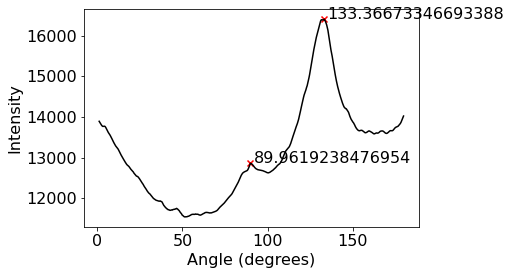

In [ ]:
z=np.abs(FFTs[0][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U]).T

thres = 100
tol = 2
d = np.linspace(1,180,500)
img_angles = radon(z,theta = d)

N,M = z.shape
Iaccu = radon(np.ones((N,M)),theta = d)
Iproj = img_angles/Iaccu


Iavg = []
Istd = []
for ii in range(len(d)):
    temp = Iproj[:,ii]
    temp_c = Iaccu[:,ii]
    temp[temp_c<thres] = 0
    temp = temp[np.nonzero(temp)]
    Istd.append(np.std(temp))
    
  
Iprojx = sum(Iproj.T)
peaks = find_peaks(Istd,prominence=100)[0] # May need to change prominence if needed
Istd = np.asarray(Istd)
plt.figure()
plt.plot(d,Istd,'k-')
plt.scatter(d[peaks],Istd[peaks],c='r',marker='x')
for ii, txt in enumerate(peaks):
    plt.annotate(str(d[peaks[ii]]),(d[peaks[ii]]+2,Istd[peaks[ii]]+2))
plt.xlabel('Angle (degrees)')
plt.ylabel('Intensity')

Line profiles of FFT intensity along the angle found above (Change line 13) and calculate the area under the central peak used for normalization. 

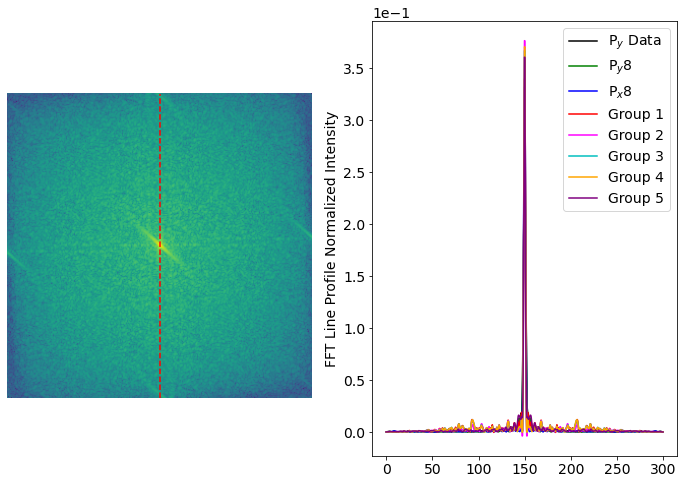

In [ ]:
z_og=(np.abs(FFTs[0][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])).T
z_y8= (np.abs(FFTs[1][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])).T
z_x8= (np.abs(FFTs[2][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])).T
z_VabA15= (np.abs(FFTs[3][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])).T
z_ab= (np.abs(FFTs[4][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])).T
z_VabA= (np.abs(FFTs[5][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])).T
z_VA= (np.abs(FFTs[6][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])).T
z_15= (np.abs(FFTs[7][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])).T

num=1000
ang = 0 # Change to angle found above with largest intensity. 
slope=np.tan(np.radians(90-ang))

b = z.shape[1]/2-z.shape[0]/2*slope
y = np.linspace(0, z.shape[1], num)
x=(y-b)/slope

zi_og = ndimage.map_coordinates(z_og, np.vstack((y,x)))
zi_y8 = ndimage.map_coordinates(z_y8, np.vstack((y,x)))
zi_x8 = ndimage.map_coordinates(z_x8, np.vstack((y,x)))
zi_VabA15 = ndimage.map_coordinates(z_VabA15, np.vstack((y,x)))
zi_ab = ndimage.map_coordinates(z_ab, np.vstack((y,x)))
zi_VabA = ndimage.map_coordinates(z_VabA, np.vstack((y,x)))
zi_VA = ndimage.map_coordinates(z_VA, np.vstack((y,x)))
zi_15 = ndimage.map_coordinates(z_15, np.vstack((y,x)))
data = [zi_og,zi_y8,zi_x8,zi_VabA15,zi_ab,zi_VabA,zi_VA,zi_15]

from scipy.integrate import simps
areas=[]
for ii in data:
  area = simps(ii[420:580],y[420:580]) #Area under center peak
  areas.append(area)

fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(12,8))
ax[0].imshow((np.abs(FFTs[0][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])/np.max(FFTs[0]).real).T,norm=LogNorm(),cmap='viridis',origin='bottom')
ax[0].axis('off')
ax[0].plot(x,y, 'r--')

ax[1].plot(y,zi_og/areas[0],'k',label='P$_y$ Data')
ax[1].plot(y,zi_y8/areas[1],'g',label='P$_y$8')
ax[1].plot(y,zi_x8/areas[2],'b',label='P$_x$8')
ax[1].plot(y,zi_VabA15/areas[3],'r',label='Group 1')
ax[1].plot(y,zi_ab/areas[4],'magenta',label='Group 2')
ax[1].plot(y,zi_VabA/areas[5],'c',label='Group 3')
ax[1].plot(y,zi_VA/areas[6],'orange',label='Group 4')
ax[1].plot(y,zi_15/areas[7],'purple',label='Group 5')
ax[1].set_ylabel('FFT Line Profile Normalized Intensity')

ax[1].ticklabel_format(style='sci',axis='y',scilimits=(0,0))
ax[1].legend()


Plot normalized FFT intensities for each descriptor group.

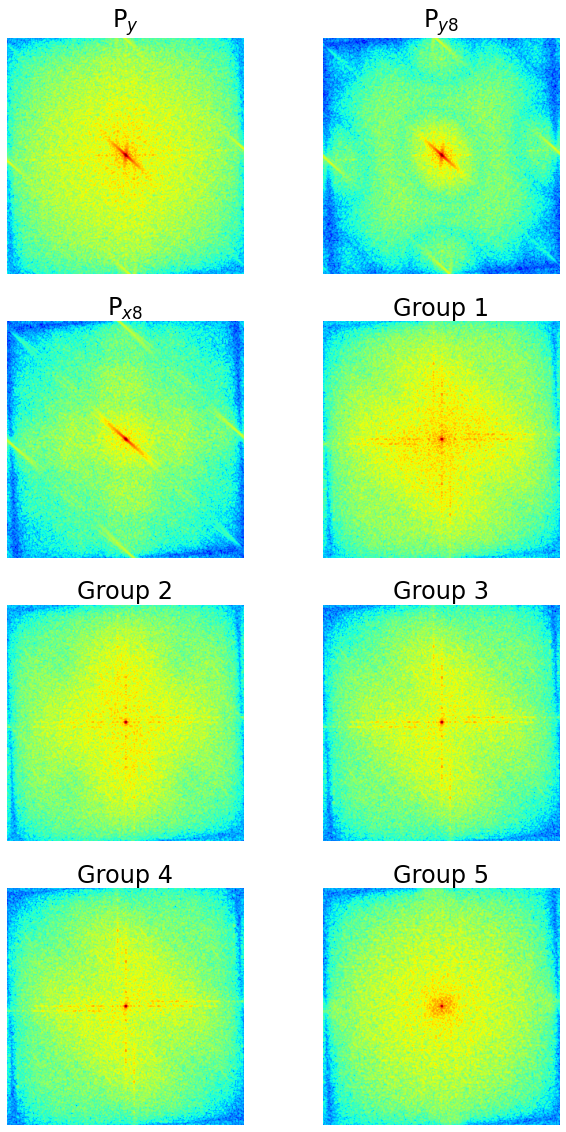

In [ ]:
plt.rcParams.update({'font.size': 20})
fig,axs = plt.subplots(ncols=2,nrows=4,figsize=(10,20))
axs[0,0].imshow(np.abs(FFTs[0][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U]/areas[0]).T,norm=LogNorm(),cmap='jet',origin='bottom')
axs[0,0].axis('off')
axs[0,0].title.set_text('P$_y$')

axs[0,1].imshow((np.abs(FFTs[1][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])/areas[1]).T,norm=LogNorm(),cmap='jet',origin='bottom')
axs[1,0].imshow((np.abs(FFTs[2][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])/areas[2]).T,norm=LogNorm(),cmap='jet',origin='bottom')
axs[1,1].imshow((np.abs(FFTs[3][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])/areas[3]).T,norm=LogNorm(),cmap='jet',origin='bottom')
axs[2,0].imshow((np.abs(FFTs[4][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])/areas[4]).T,norm=LogNorm(),cmap='jet',origin='bottom')
axs[2,1].imshow((np.abs(FFTs[5][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])/areas[5]).T,norm=LogNorm(),cmap='jet',origin='bottom')
axs[3,0].imshow((np.abs(FFTs[6][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])/areas[6]).T,norm=LogNorm(),cmap='jet',origin='bottom')
axs[3,1].imshow((np.abs(FFTs[7][int(nn/2)-U:int(nn/2)+U,int(mm/2)-U:int(mm/2)+U])/areas[7]).T,norm=LogNorm(),cmap='jet',origin='bottom')
axs[0,1].axis('off')
axs[1,0].axis('off')
axs[1,1].axis('off')
axs[2,0].axis('off')
axs[2,1].axis('off')
axs[3,0].axis('off')
axs[3,1].axis('off')
axs[0,1].title.set_text('P$_{y8}$')
axs[1,0].title.set_text('P$_{x8}$')
axs[1,1].title.set_text('Group 1')
axs[2,0].title.set_text('Group 2')
axs[2,1].title.set_text('Group 3')
axs[3,0].title.set_text('Group 4')
axs[3,1].title.set_text('Group 5')
plt.subplots_adjust(wspace=0.3, hspace=0.2)


Plot the normalized intensity at a designated section of the line profile.  You may need to change the indicies of the line profiles in line 4 (currently set up for the 20% Sm: BFO data). 

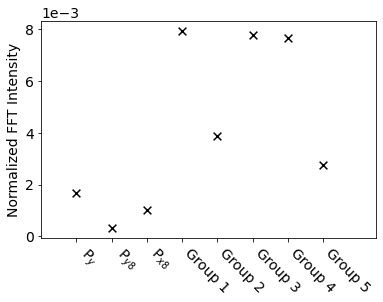

In [ ]:
plt.rcParams.update({'font.size': 14})
lbs = ['P$_{y8}$','P$_{x8}$']
labels = lbs+['Group '+str(i+1) for i in range(5)]
fft_int = [np.max(zi_og[183:300]),np.max(zi_y8[183:300]),np.max(zi_x8[183:300]),np.max(zi_VabA15[183:300]),np.max(zi_ab[183:300]),np.max(zi_VabA[183:300]),np.max(zi_VA[183:300]),np.max(zi_15[183:300])]
fig3,ax3 = plt.subplots()
ax3.scatter(np.arange(len(fft_int)),np.asarray(fft_int)/np.asarray(areas), marker='x', c='black', s=60)
ax3.set_xticks(np.arange(len(labels)+1))
ax3.set_xticklabels(['P$_y$']+labels, rotation=-45, ha='left')
ax3.set_ylabel('Normalized FFT Intensity', fontsize=14)
ax3.tick_params(axis='both', labelsize=14)
ax3.set_xlim(-1, len(labels)+1.5)
# ax3.set_ylim(0,5e-2) # Set axes as you see fit
ax3.ticklabel_format(style='sci',axis='y',scilimits=(0,0))
